In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community
!pip install wikipedia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.1/417.1 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.45
    Uninstalling langchain-core-0.3.45:
      Successfully uninstalled langchain-core-0.3.45
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.6
    Uninstalling langchain-text-splitters-0.3.6:
      Successfully un

In [2]:
from typing  import Annotated
from typing_extensions import TypedDict

## Creating Wikipedia Tool


In [10]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.11/dist-packages/wikipedia/__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=300))

In [11]:
tools = [wiki_tool]

In [38]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]

## Loading LLM

In [39]:
from google.colab import userdata

groq_api_key = userdata.get('groq')

In [40]:
from langchain_groq import ChatGroq

llm = ChatGroq(groq_api_key=groq_api_key, model_name='llama3-8b-8192')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7aeacddddcd0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7aeace22b350>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

## bind LLM with Wikipedia tool

In [41]:
llm_with_tool = llm.bind_tools(tools=tools)
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7aeacddddcd0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7aeace22b350>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'query to look up on wikipedia', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [42]:
def chatbot(state:State):
  return {'messages': [llm_with_tool.invoke(state['messages'])]}

## Create Graph

In [43]:
graph_builder = StateGraph(State)
graph_builder

In [44]:
from langgraph.prebuilt import ToolNode, tools_condition

## Join Graph with LLM and Tool

In [45]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

## Compile Graph and Visualize Flow of Graph

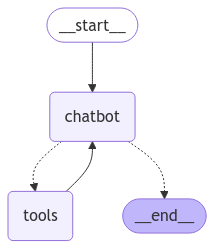

In [54]:
graph = graph_builder.compile()
graph

## Ask Query to Agent

In [58]:
user_input = input('User: ')

events = graph.stream({'messages': [("user", user_input)]}, stream_mode="values")

for event in events:
  event['messages'][-1].pretty_print()

User: at which location mahabharata war was happned ?
================================ Human Message =================================

at which location mahabharata war was happned ?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_vdm4)
 Call ID: call_vdm4
  Args:
    query: Location of Mahabharata War
================================= Tool Message =================================
Name: wikipedia

Page: Kurukshetra War
Summary: The Kurukshetra War (Sanskrit: कुरुक्षेत्र युद्ध), also called the Mahabharata War, is a war described in the Hindu epic poem Mahabharata, arising from a dynastic struggle between two groups of cousins, the Kauravas and the Pandavas, for the throne of Hastinapura. The 
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_wdwd)
 Call ID: call_wdwd
  Args:
    query: Kurukshetra
================================= Tool Message ==================